In [1]:
%pip install drfp
%pip install kneed
%pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.7 MB/s 
     |████████████████████████████████| 96 kB 6.2 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from drfp import DrfpEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [33]:
df = pd.read_csv('датасет 4000 реакций (с первых 100 страниц SF).csv', delimiter=';')

In [34]:
#отделяем датасет, где известны все смайлзы
for idx in df.index:
  if 'None' in df.loc[idx, 'reactants_smiles'] or 'None' in df.loc[idx, 'products_smiles']:
    df.drop(labels=idx, inplace=True)
df = df.reset_index(drop=True)
df.head(30)

,reaction_id,stages_number,yield_value,reactants,products,title,authors,bibliography,other_conditions_1,temperature,...,catalysts_1,catalysts_1_2,solvents_1,other_conditions_2,reagents_2,catalysts_2,solvents_2,solvents_1_2,reactants_smiles,products_smiles
0,31-614-CAS-26539186,1,100.0,110-54-3,74-82-8,Dehydrocyclization of n-hexane over heteropoly...,"Eid, Abdellah",Advances in Chemical Engineering and Science (...,400 °C,400.0,...,2245045-74-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCC,C
1,31-614-CAS-28519743,1,96.0,110-54-3,74-82-8,Hierarchical H-ZSM-5-supported cobalt for the ...,"Sartipi, Sina","Journal of Catalysis (2013), 305, 179-190","15 bar, 493 K",220.0,...,Cobalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCC,C
2,31-614-CAS-30341229,2,93.0,110-54-3,74-82-8,Different Catalytic Reactions of n-Hexane and ...,"Al-Kharafi, F.","Catalysis Letters (2008), 123(3-4), 269-275","24 h, 873 K",600.0,...,Molybdenum oxide (MoO3),NaN,NaN,873 K,Hydrogen,NaN,NaN,NaN,CCCCCC,C
3,31-614-CAS-30602615,1,100.0,112-80-1,74-82-8,Preparation method of methane by fatty acid hy...,"Zhang, Jing","China, CN109776248 A 2019-05-21","10 h, rt → 360 °C",192.5,...,Rhodium,NaN,Water,NaN,NaN,NaN,NaN,NaN,CCCCCCCC/C=C/CCCCCCCC(O)=O,C
4,31-614-CAS-28368873,1,100.0,124-38-9,74-82-8,Accessing Two-Coordinate ZnII Organocations by...,"Specklin, David","Chemistry - A European Journal (2017), 23(63),...","1.5 bar, rt",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C=O,C
5,31-614-CAS-29967082,1,87.0,124-38-9,74-82-8,Characteristics of adapted hydrogenotrophic co...,"Rachbauer, Lydia","Science of the Total Environment (2017), 595, ...","4 d, 38 °C",38.0,...,NaN,NaN,Water,NaN,NaN,NaN,NaN,NaN,O=C=O,C
6,31-614-CAS-30730219,1,82.0,124-38-9,74-82-8,Selective Reduction of CO2 to CH4 by Tandem Hy...,"Chen, Jiawei",Journal of the American Chemical Society (2016...,"5 h, 100 °C",100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C=O,C
7,31-614-CAS-29824211,1,100.0,144-62-7,74-84-0,Catalytic hydrosilylation of oxalic acid: chem...,"Feghali, Elias","Catalysis Science & Technology (2014), 4(8), 2...",rt,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OC(=O)C(O)=O,CC
8,31-614-CAS-25741386,1,100.0,15194-58-8.2050-77-3,1120-21-4,Reactions of new organocuprates. 2. Substituti...,"Ashby, Eugene C.","Journal of Organic Chemistry (1977), 42(17), 2...",NaN,NaN,...,NaN,NaN,Tetrahydrofuran,NaN,NaN,NaN,NaN,NaN,[CH3-] ; CCCCCCCCCCI,CCCCCCCCCCC
9,31-614-CAS-27974066,1,100.0,57-11-4.57-10-3,74-82-8,Preparation method of methane by fatty acid hy...,"Zhang, Jing","China, CN109776248 A 2019-05-21","5 h, rt → 400 °C",212.5,...,Ruthenium,NaN,Water,NaN,NaN,NaN,NaN,NaN,CCCCCCCCCCCCCCCCCC(O)=O ; CCCCCCCCCCCCCCCC(O)=O,C


In [35]:
#соединяем смайлзы реагентов и продуктов в общий смайлз реакции
rxn_smiles=[]
for idx in df.index:
  reactants = df.loc[idx, 'reactants_smiles'].split(' ; ')
  reactants = '.'.join(reactants)
  products = df.loc[idx, 'products_smiles'].split(' ; ')
  products = '.'.join(products)
  rxn = reactants + '>>' + products
  rxn_smiles.append(rxn)

In [42]:
#перевод в фингерпринты

list_fps_reaction = []
for i in rxn_smiles:
  fp = DrfpEncoder.encode(i, n_folded_length=512)
  list_fps_reaction.append(fp)

In [37]:
print(len(list_fps_reaction))

2776


In [43]:
X = np.array(list_fps_reaction)
X = X.reshape(2776, 512)
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
def elbow(scores, n): #график score от k
  plt.figure(figsize=(15,4))
  plt.title("The elbow method for determining number of clusters\n",fontsize=16)
  plt.scatter(x=[i for i in range(2,n)],y=scores,s=150,edgecolor='k')
  plt.grid(True)
  plt.xlabel("Number of clusters",fontsize=14)
  plt.ylabel("K-means score",fontsize=15)
  plt.xticks([i for i in range(2,n)],fontsize=14)
  plt.yticks(fontsize=15)
  plt.show()

In [39]:
def sil_plot(sil, n): #график силуэта от k
  plt.figure(figsize=(15,4))
  plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
  plt.scatter(x=[i for i in range(2,n)],y=sil,s=150,edgecolor='k')
  plt.grid(True)
  plt.xlabel("Number of clusters",fontsize=14)
  plt.ylabel("Silhouette score",fontsize=15)
  plt.xticks([i for i in range(2,n)],fontsize=14)
  plt.yticks(fontsize=15)
  plt.show()

In [44]:
km_silhouette = []
km_scores= []
m = 16
for n in range(2, m):
  kmeans = KMeans(n_clusters=n, init='random', algorithm='elkan', n_init=10, random_state=100).fit(X)
  preds = kmeans.predict(X)
  score = kmeans.score(X)
  silhouette = silhouette_score(X,preds)
  km_scores.append(-score)
  km_silhouette.append(silhouette)

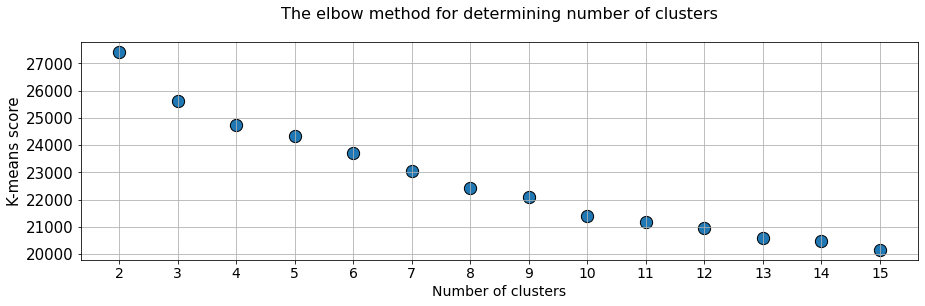

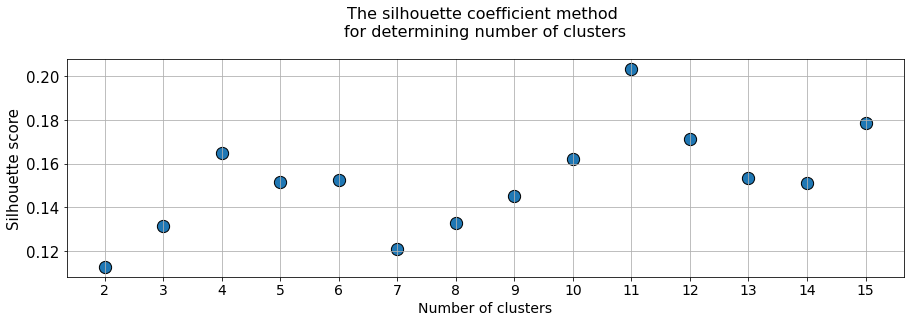

In [45]:
elbow(km_scores, m)
sil_plot(km_silhouette, m)

In [46]:
kmeans = KMeans(n_clusters=11, init='random', algorithm='elkan', n_init=10, random_state=100).fit(X)
df['cluster']=kmeans.predict(X)
df['fp']=list_fps_reaction
df1 = df[df['cluster']==3]
df1 = df1.drop_duplicates(subset=['reactants_smiles', 'products_smiles'], keep='first')
df1[['reaction_id', 'reactants_smiles', 'products_smiles', 'cluster']].head(50)

,reaction_id,reactants_smiles,products_smiles,cluster
280,31-614-CAS-25681623,N#CC(=Cc1cccc2ccccc12)C#N ; CC,CCC(C(C#N)C#N)c1cccc2ccccc12,3
318,31-614-CAS-33391026,C\C=C\C ; C\C=C/C ; CC(C)=C ; CCC=C ; CCCC ; C...,CCOC(C)(C)C,3
384,31-614-CAS-31570448,C=CC(=O)Nc1ccccc1 ; CC,CCCCC(=O)Nc1ccccc1,3
402,31-614-CAS-31570436,C=CC(=O)Oc1ccccc1 ; CC,CCCCC(=O)Oc1ccccc1,3
445,31-614-CAS-29689064,C=CCCC=C,C,3
557,31-614-CAS-27633866,CC,CC=C ; C=C,3
580,31-479-CAS-23638246,CCC,CC=C ; C,3
640,31-214-CAS-8250005,C ; CC(C)=O,CC(=O)C=C ; CCC(C)=O,3
641,31-614-CAS-31121631,CCCC,CC=C ; C,3
650,31-614-CAS-24758116,CC(C)=C ; CCC=C ; CCCC ; CC(C)C ; CCC ; CC,CC=C ; C=C,3


Text(0, 0.5, 'Distance')

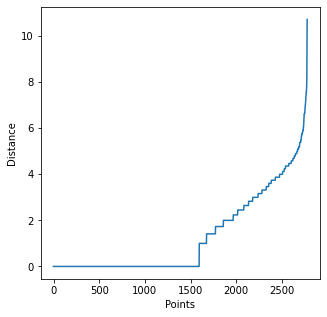

In [47]:
#определение оптимального eps для DBSCAN

from sklearn.neighbors import NearestNeighbors
#k=ln(n) where n is the number of points to be clustered
nearest_neighbors = NearestNeighbors(n_neighbors=8)
neighbors = nearest_neighbors.fit(X)

distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,7], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

3.7416573867739413


<Figure size 360x360 with 0 Axes>

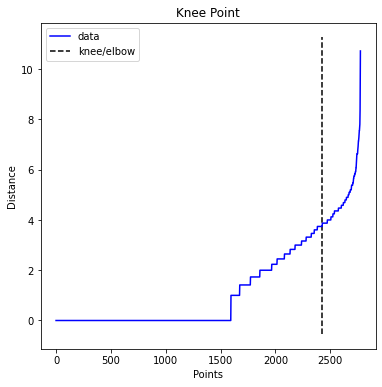

In [48]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
a = distances[knee.knee]
print(a)

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import v_measure_score
from rdkit.Chem import DataStructs
import numpy

dbs = DBSCAN(eps=a, min_samples=8, metric='euclidean').fit(X)
labels = dbs.labels_

N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)
n_noise = list(dbs.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

Estimated no. of clusters: 7
Estimated no. of noise points: 278


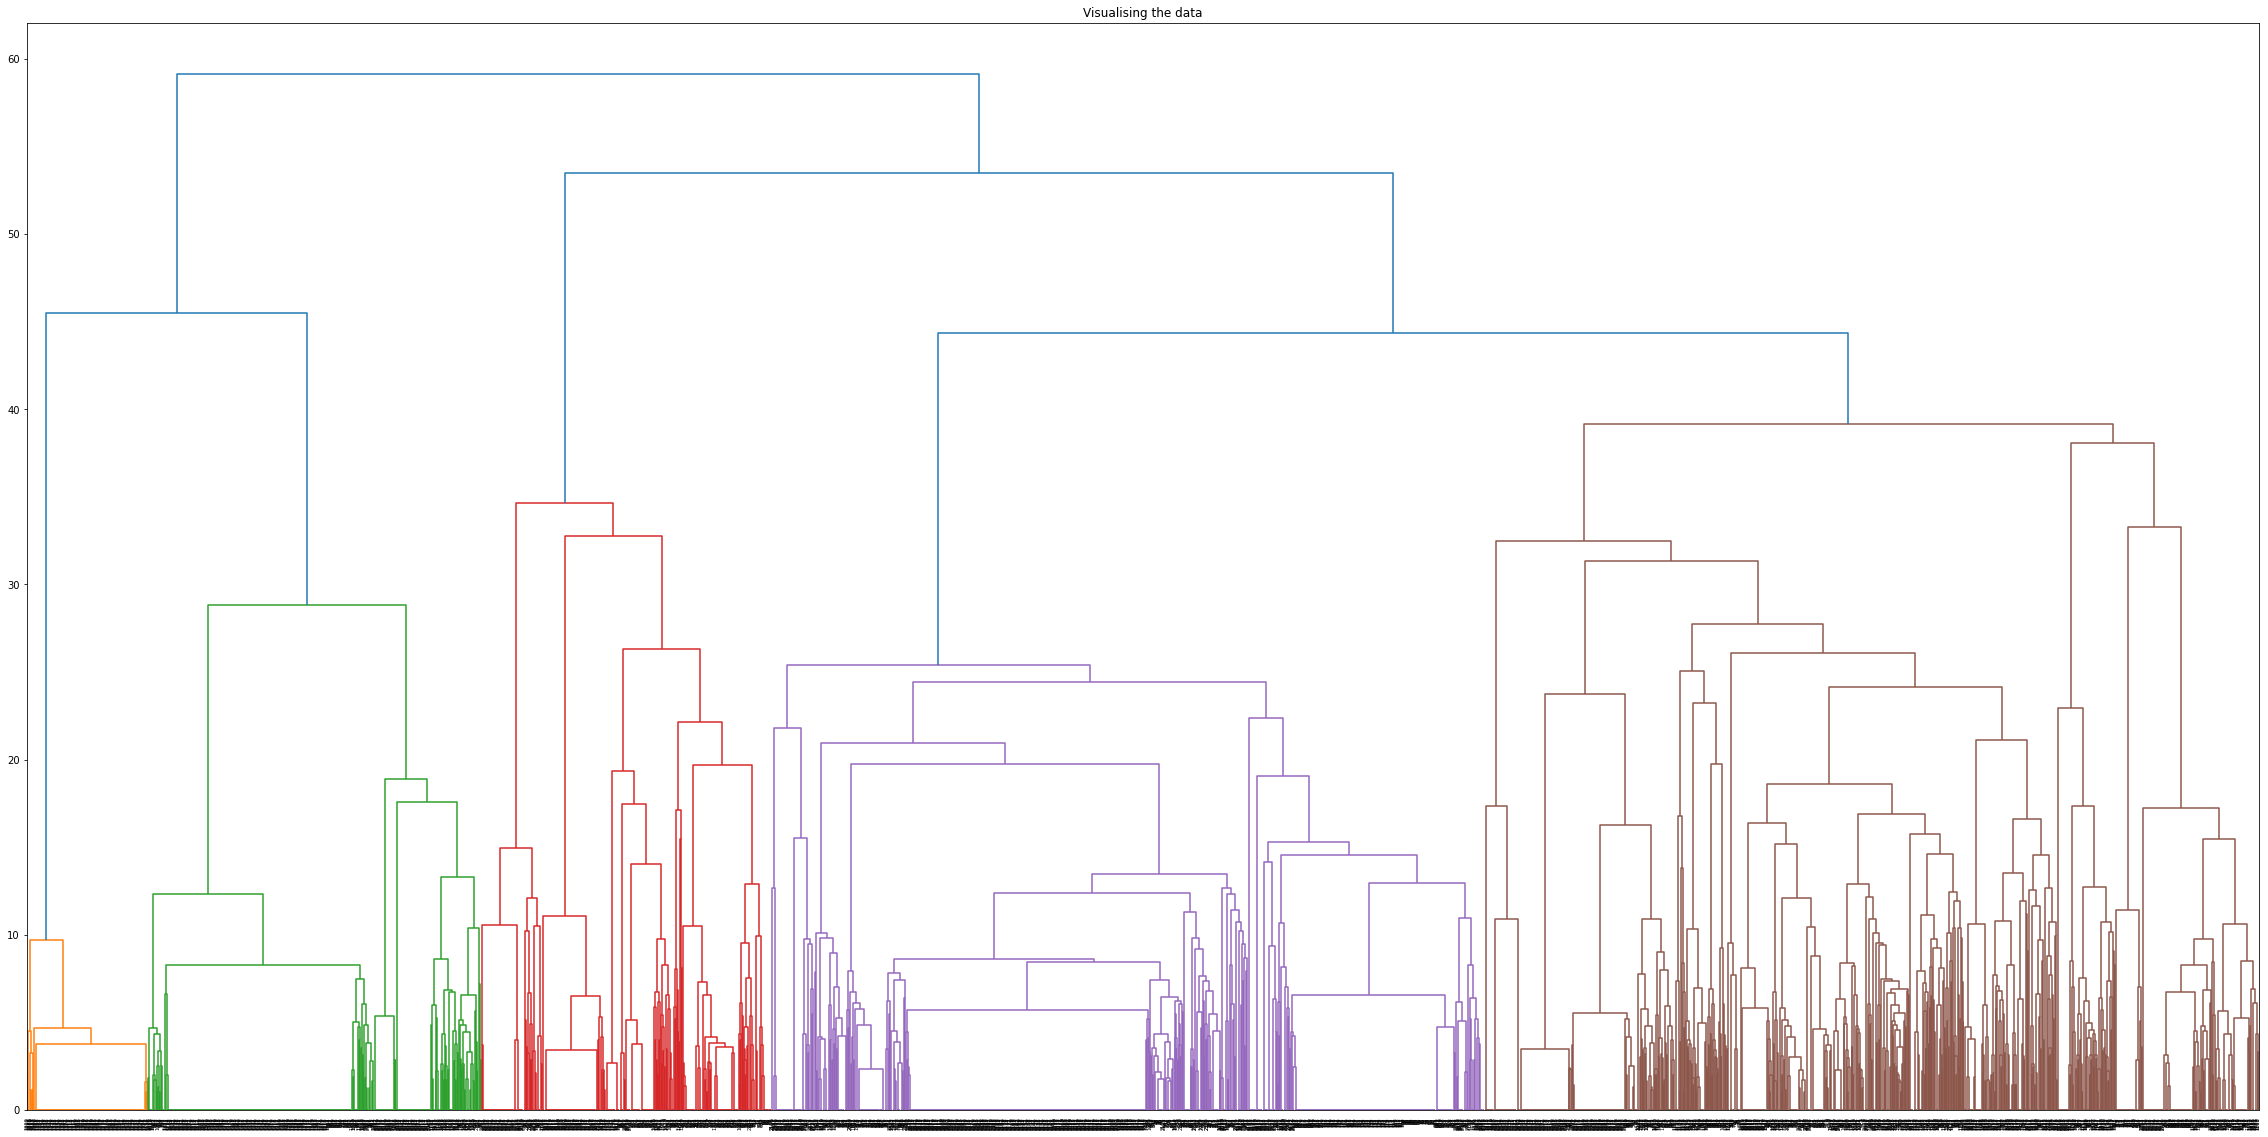

In [50]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
plt.figure(figsize =(40, 20))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X, method ='ward')))

In [89]:
#подбор оптимального linkage

for link in ['ward', 'single', 'average', 'complete']:
  ag = AgglomerativeClustering(linkage=link, n_clusters=5).fit(X)
  preds = ag.fit_predict(X)
  silhouette = silhouette_score(X,preds)
  cl = ag.n_clusters_
  print(link, silhouette, cl)

ward 0.1272073629020246 5
single 0.49533606055401425 5
average 0.5041360892510048 5
complete 0.4666786337345245 5


Average самый оптимальный при любом кол-ве кластеров.
Силуэт и кол-во класстеров от метрики не сильно зависит.

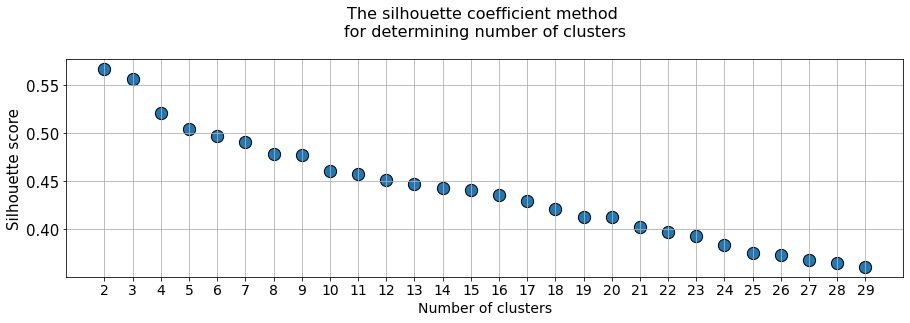

In [85]:
#подбор оптимального кол-ва кластеров
ag_sil = []
m = 30
for n in range(2, m):
  ag = AgglomerativeClustering(linkage='average', n_clusters=n, affinity='euclidean').fit(X)
  preds = ag.fit_predict(X)
  silhouette = silhouette_score(X,preds)
  cl = ag.n_clusters
  ag_sil.append(silhouette)
sil_plot(ag_sil, m)

In [88]:
ag = AgglomerativeClustering(linkage='average', n_clusters=11, affinity='euclidean').fit(X)
preds = ag.fit_predict(X)
silhouette_score(X,preds)

0.45750360271475116

In [105]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(X)
X_embedded

array([[ -2.659053 ,  10.145599 ],
       [ -2.6607132,  10.144476 ],
       [ -2.659903 ,  10.144817 ],
       ...,
       [-37.28254  ,   8.810756 ],
       [ 27.83311  , -17.520777 ],
       [ 27.833033 , -17.520695 ]], dtype=float32)

In [106]:
import plotly.express as px
x=X_embedded[:,0]
y=X_embedded[:,1]
# Создание диаграммы разброса
fig = px.scatter(None, x, y, 
                 labels={
                     "x": "Dimension 1",
                     "y": "Dimension 2",
                 },
                 opacity=1, color=y.astype(str))

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE")

# Обновление размера маркера
fig.update_traces(marker=dict(size=3))

fig.show()